In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [3]:
# hyperparameters
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다: ", DEVICE)

다음 장치를 사용합니다:  cuda


In [4]:
# Fashion MNIST 
trainset = datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ]))

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [7]:
# 모델 인스턴스를 만들고 모델 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# Binary Cross Entropy Loss function
# Adam Optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [11]:
total_step = len(train_loader)
print("{} batches per 1 Epoch".format(total_step))

TRAINING=False
if TRAINING:
    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(BATCH_SIZE, -1).to(DEVICE)

            # '진짜' 와 '가짜' label 생성
            real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
            fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

            # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산(True positive)
            labels = labels.to(DEVICE)
            outputs = D(images, labels)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
            z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
            g_label = torch.randint(0, 10, (BATCH_SIZE, )).to(DEVICE)
            fake_images = G(z, g_label)

            # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산(True Negative)
            outputs = D(fake_images, g_label)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # 진짜와 가짜 이미지를 가지고 낸 오차를 더해서 판별자의 오차 계산
            d_loss = d_loss_real + d_loss_fake

            # BackPropagation으로 판별자 모델의 학습을 진행
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 생성자가 판별자를 속였는지에 대한 오차를 계산 (False Positive)
            fake_images = G(z, g_label)
            outputs = D(fake_images, g_label)
            g_loss = criterion(outputs, real_labels)

            # BackPropagation으로 생성자 모델의 학습을 진행
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        print("EPOCH: [{}/{}] d_loss: {:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}".format(
            epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()
        ))
    torch.save(D.state_dict(), './snapshot/conditional_gan_discriminator.pt')
    torch.save(G.state_dict(), './snapshot/conditional_gan_generator.pt')
else:
    D.load_state_dict(torch.load('./snapshot/conditional_gan_discriminator.pt'))
    G.load_state_dict(torch.load('./snapshot/conditional_gan_generator.pt'))

600 batches per 1 Epoch


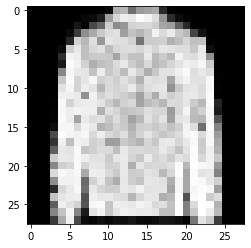

In [12]:
# Visualization
item_table = { idx: name for idx, name in enumerate(datasets.FashionMNIST.classes)}

item_number = 4
z = torch.randn(1, 100).to(DEVICE)    # 배치 크기 1
g_label = torch.full((1, ), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0], (28, 28))

plt.imshow(sample_images_img, cmap='gray')
plt.show()